The goal for this workbook is to predict the price of an AirBnB listing for a test dataset.

In [2017]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
from imblearn import over_sampling
import seaborn as sns
import datetime
from geopy.geocoders import Nominatim
import math

In [2018]:
df_train=pd.read_csv("C:/Users/namhpham/Documents/Personal files/Data Science/AirBnb/Original/train.csv")
df_test=pd.read_csv("C:/Users/namhpham/Documents/Personal files/Data Science/AirBnb/Original/test.csv")

Viewing the datasets attributes

In [2019]:
df_train.shape

(74111, 29)

In [2020]:
df_test.shape

(25458, 28)

In [2021]:
df_train.iloc[:3,:15]

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,NYC,"Beautiful, sunlit brownstone 1-bedroom in the ...",2016-06-18,t,t
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,NYC,Enjoy travelling during your stay in Manhattan...,2017-08-05,t,f
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,NYC,The Oasis comes complete with a full backyard ...,2017-04-30,t,t


Joining train and test dataset together. The test dataset does not have the `log_price` attribute

In [2022]:
df_train['label']='train'
df_test['label']='test'

df_concat=pd.concat([df_train,df_test])
df_concat.zipcode=df_concat['zipcode'].astype(str)

In [2023]:
df_concat['Dollar_price']=np.exp(df_concat['log_price'])
df_train['Dollar_price']=np.exp(df_train.log_price)

Exploratory Data Analysis

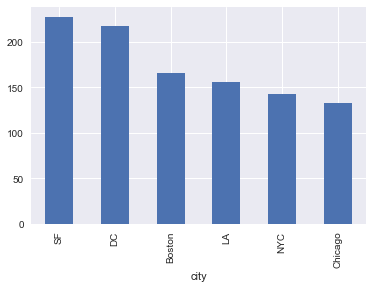

In [2024]:
Price_by_city=df_concat.groupby('city')['Dollar_price'].mean()
Price_by_city=Price_by_city.sort_values(ascending=False)
plot1=Price_by_city.plot.bar()

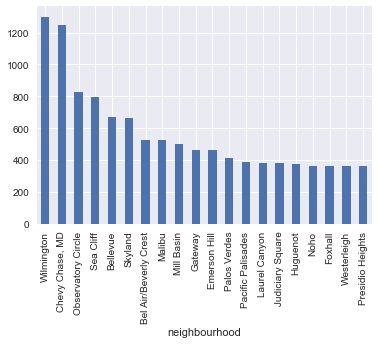

In [2025]:
Price_by_neighbourhood=df_concat.groupby('neighbourhood')['Dollar_price'].mean()
Price_by_neighbourhood=Price_by_neighbourhood.sort_values(ascending=False)
plot2=Price_by_neighbourhood.head(20).plot.bar()

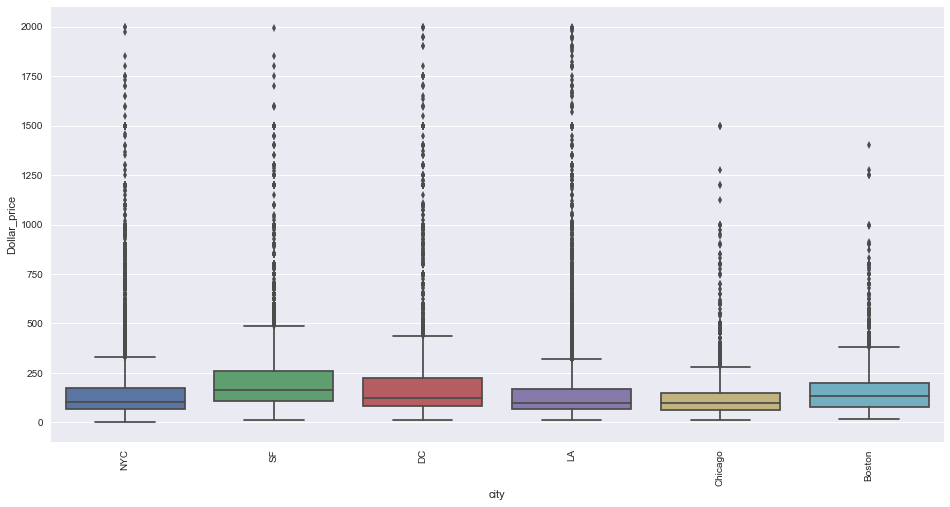

In [2026]:
var = 'city'
data = pd.concat([df_concat['Dollar_price'], df_concat[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="Dollar_price", data=data)
#fig.yaxis.set_major_formatter(tick) 
#fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

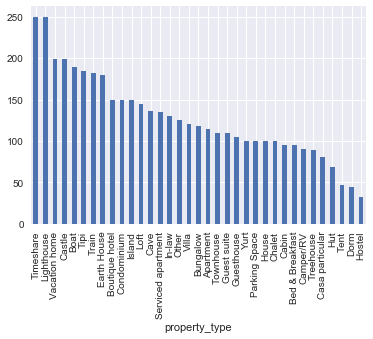

In [2027]:
Price_by_property=df_concat.groupby('property_type')['Dollar_price'].median()
Price_by_property=Price_by_property.sort_values(ascending=False)
plot3=Price_by_property.plot.bar()

Viewing the distribution of price. The majority are in $50-200 range

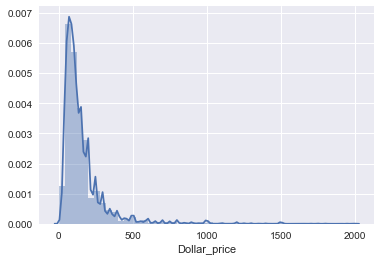

In [2028]:
sns.distplot(df_concat['Dollar_price'].dropna())

Cleaning the data. Because location is an important factor in pricing, we want to have a good variable to determine this. However, city is too broad (only 5 levels), while neighborhood is too detail (800 levels). We want to come up with a variable that can explain better. We will come up with 5 categories based on pricing. We will group neighbourhood into these categories.

Fix zip code

In [2029]:
col=list(df_concat.zipcode)

In [2030]:
col=[str(x)[:5] for x in col]

In [2031]:
df_concat.zipcode=col
df_concat.zipcode=df_concat['zipcode'].astype(str)

create lookup table

In [2032]:
data=pd.DataFrame(df_concat[['zipcode','neighbourhood']])
data=data.dropna()

In [2033]:
look_up=data.set_index('zipcode')['neighbourhood'].to_dict()

In [2034]:
df_concat['neighbourhood']=df_concat.zipcode.map(look_up)

In [2035]:
df_concat['neighbourhood'].isnull().sum()

1122

For the listing without neighbourbood, we label them as the City they belong to (NY, DC, Boston, Chicago, or LA)

In [2036]:
df_concat['neighbourhood']=df_concat['neighbourhood'].fillna(df_concat['city'])

In [2037]:
#df_concat.loc[df_concat.label=='test','Category']='Category_1'
#df_test['Category']='Category_1'

In [2038]:
for i in (50,80,97,99):
    print(np.percentile(test2['Dollar_price'],i))

94.0
150.0
259.0
464.91


In [2039]:
test2=pd.DataFrame(df_train.groupby('neighbourhood')['Dollar_price'].median())

In [2040]:
test2['neighbourhood']=test2.index

In [2041]:
test2['Category']=1

In [2042]:
test2.loc[test2.Dollar_price>=94,'Category']=2
test2.loc[test2.Dollar_price>=150,'Category']=3
test2.loc[test2.Dollar_price>=259,'Category']=4
test2.loc[test2.Dollar_price>=464,'Category']=5


In [2043]:
look_up2=test2.set_index('neighbourhood')['Category'].to_dict()

In [2044]:
df_concat['Category']=df_concat.neighbourhood.map(look_up2)

For Category not filled, we put them in category 1.

In [2045]:
df_concat['Category']=df_concat['Category'].fillna(1)

We also try to fill some missing information. Most listing has 1 bed and 1 bathroom, so we give this default value

In [2046]:
df_concat['beds']=df_concat['beds'].fillna(1)
df_concat['bathrooms']=df_concat['bathrooms'].fillna(1)
df_concat['bathrooms']=df_concat['bathrooms'].astype(int)
df_concat['beds']=df_concat['beds'].astype(int)

Number of amenities are text string, separated by `,` character. As a result, we can do a simple calculation of number of amenities by counting the number of `,` character plus one. We do not distinguish between one amenity from the other.

In [2047]:
df_concat['number_amenities']=df_concat['amenities'].apply(lambda x: x.count(',')+1)

In [2048]:
df_concat['room_type'].value_counts()

Entire home/apt    55482
Private room       41082
Shared room         3005
Name: room_type, dtype: int64

We try to give a rating value for room type on a scale of 5. For entire house, the price will likely to be higher, so we give them a score of 5. We also follow this logic for property type and bed type

In [2049]:
df_concat.loc[df_concat.room_type=='Entire home/apt','room_type_rating']=5
df_concat.loc[df_concat.room_type=='Private room','room_type_rating']=3
df_concat.loc[df_concat.room_type=='Shared room','room_type_rating']=1

In [2050]:
df_concat['property_type'].value_counts()

Apartment             65675
House                 22321
Condominium            3609
Townhouse              2234
Loft                   1681
Other                   805
Guesthouse              672
Bed & Breakfast         625
Bungalow                483
Villa                   237
Dorm                    203
Guest suite             172
Camper/RV               125
Timeshare               108
Hostel                  101
Boutique hotel          100
In-law                   99
Cabin                    91
Boat                     87
Serviced apartment       27
Tent                     20
Vacation home            16
Castle                   15
Treehouse                14
Yurt                     12
Hut                       8
Earth House               8
Chalet                    7
Tipi                      4
Train                     3
Cave                      3
Parking Space             1
Casa particular           1
Island                    1
Lighthouse                1
Name: property_type,

In [2051]:
df_concat.loc[df_concat.property_type=='House','property_type_rating']=5
df_concat.loc[df_concat.property_type=='Condomium','property_type_rating']=5
df_concat.loc[df_concat.property_type=='Townhouse','property_type_rating']=5
df_concat.loc[df_concat.property_type=='Villa','property_type_rating']=5
df_concat.loc[df_concat.property_type=='Apartment','property_type_rating']=4
df_concat['property_type_rating']=df_concat['property_type_rating'].fillna(1)

In [2052]:
df_concat['bed_type'].value_counts()

Real Bed         96805
Futon              993
Pull-out Sofa      783
Airbed             645
Couch              343
Name: bed_type, dtype: int64

In [2053]:
df_concat['bed_type_rating']=1
df_concat.loc[df_concat.bed_type=='Real Bed','bed_type_rating']=5
df_concat.loc[df_concat.bed_type=='Futon','bed_type_rating']=3

In [2054]:
df_concat['host_identity_verified_rating']=1
df_concat.loc[df_concat.host_identity_verified=='t']=5

In [2055]:
df_concat['review_scores_rating']=df_concat['review_scores_rating'].fillna(df_concat['review_scores_rating'].median())

Building the model

In [2056]:
keep_cols=['id','label','log_price','room_type_rating',
               'accommodates','bathrooms','Category',
               'number_of_reviews', 'beds','number_amenities','property_type_rating']

In [2057]:
#features_df=pd.get_dummies(df_concat,columns=['property_type'])
df_train2=features_df[features_df['label']=='train']
df_test2=features_df[features_df['label']=='score']

Viewing the dataset used for building the model

In [2058]:
df_concat2=df_concat[keep_cols]

In [2059]:
df_train2.head()

,Category,Dollar_price,accommodates,amenities,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,...,property_type_Serviced apartment,property_type_Tent,property_type_Timeshare,property_type_Tipi,property_type_Townhouse,property_type_Train,property_type_Treehouse,property_type_Vacation home,property_type_Villa,property_type_Yurt
0,2.0,150.0,3,"{""Wireless Internet"",""Air conditioning"",Kitche...",1,Real Bed,1.0,1,strict,NYC,...,0,0,0,0,0,0,0,0,0,0
1,3.0,169.0,7,"{""Wireless Internet"",""Air conditioning"",Kitche...",1,Real Bed,3.0,3,strict,NYC,...,0,0,0,0,0,0,0,0,0,0
2,2.0,145.0,5,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",1,Real Bed,1.0,3,moderate,NYC,...,0,0,0,0,0,0,0,0,0,0
3,2.0,750.0,4,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",1,Real Bed,2.0,2,flexible,SF,...,0,0,0,0,0,0,0,0,0,0
4,2.0,115.0,2,"{TV,Internet,""Wireless Internet"",""Air conditio...",1,Real Bed,0.0,1,moderate,DC,...,0,0,0,0,0,0,0,0,0,0


In [2060]:
# Take out train and test model
df_train2=df_concat2[df_concat2['label']=='train']
df_test2=df_concat2[df_concat2['label']=='test']

In [2061]:
df_train2=df_train2.drop(['label','id'],axis=1)
df_test2=df_test2.drop('label',axis=1)

In [2062]:
training_features,val_features,training_target,val_target=train_test_split(df_train2.drop('log_price',axis=1),df_train2['log_price'],test_size=0.2, random_state=12)

In [2063]:
x_train,x_val,y_train,y_val=train_test_split(training_features, training_target,test_size=.2, random_state=12)

In [2064]:
sample_leaf_options = [1,5,10,50,100,200,500]

In [2065]:
from sklearn.ensemble import RandomForestRegressor
for leaf_size in sample_leaf_options :
    rf = RandomForestRegressor(n_estimators=200, oob_score=True, n_jobs = -1,random_state=50, max_features = "auto", min_samples_leaf = leaf_size)

In [2066]:
rf.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=500, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
           oob_score=True, random_state=50, verbose=0, warm_start=False)

In [2067]:
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr
predicted_train = rf.predict(x_train)
predicted_val = rf.predict(x_val)

test_score = r2_score(y_val, predicted_val)
spearman = spearmanr(y_val, predicted_val)
pearson = pearsonr(y_val, predicted_val)
print(f'Out-of-bag R-2 score estimate: {rf.oob_score_:>5.3}')
print(f'Test data R-2 score: {test_score:>5.3}')
print(f'Test data Spearman correlation: {spearman[0]:.3}')
print(f'Test data Pearson correlation: {pearson[0]:.3}')

Out-of-bag R-2 score estimate: 0.527
Test data R-2 score: 0.549
Test data Spearman correlation: 0.775
Test data Pearson correlation: 0.742


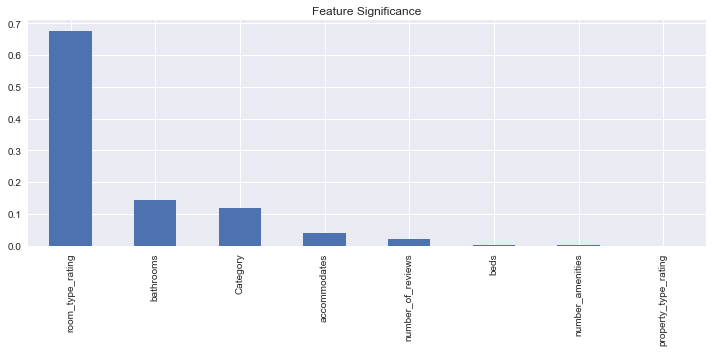

In [2068]:
coef = pd.Series(rf.feature_importances_, index = x_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
coef.head(25).plot(kind='bar')
plt.title('Feature Significance')
plt.tight_layout()

In [2069]:
print(rf.score(x_val,y_val))

0.548635615058


In [2070]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_val,rf.predict(x_val))

0.26592811752635537

In [2071]:
print('Train RMSE: ' + str(math.sqrt(mean_squared_error(y_train, rf.predict(x_train)))))

Train RMSE: 0.5183367362307131


In [2072]:
print ('Validation RMSE: ' + str(math.sqrt(mean_squared_error(y_val,rf.predict(x_val)))))


Validation RMSE: 0.5156821865513248


In [2073]:
from sklearn import datasets, linear_model
regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [2074]:
math.sqrt(mean_squared_error(y_val,regr.predict(x_val)))

0.4974410515418656

In [2075]:
from sklearn import neighbors
n_neighbors = 5

for i, weights in enumerate(['uniform', 'distance']):
    knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
    y_ = knn.fit(x_train, y_train).predict(x_val)

In [2076]:
from sklearn.datasets import make_friedman1
from sklearn.ensemble import GradientBoostingRegressor

est = GradientBoostingRegressor(n_estimators=500, learning_rate=0.1,
     max_depth=1, random_state=0, loss='ls').fit(x_train, y_train)
mean_squared_error(y_val, est.predict(x_val))  

0.23131316573603916

In [2077]:
math.sqrt(mean_squared_error(y_train,est.predict(x_train)))

0.48542096192757944

In [2078]:
math.sqrt(mean_squared_error(y_val,est.predict(x_val)))

0.48095027366250576

In [2079]:
df_test2.log_price=est.predict(df_test2.drop(['log_price','id'],axis=1))

In [2081]:
output=pd.DataFrame()

In [2082]:
output['id']=df_test2["id"]
output['log_price']=df_test2['log_price']

In [2083]:
output.head()

,id,log_price
0,3895911,4.382746
7,14402792,5.157678
9,830490,4.703033
11,18375967,4.523807
16,4000249,5.419883


In [2084]:
#output.to_csv("C:/Users/namhpham/Documents/Personal files/Data Science/AirBnb/submission_v7.csv",index=False)